In [2]:
import numpy                    as np
import pandas                   as pd
import matplotlib.pyplot        as plt 
import seaborn                  as sns
import plotly.express           as px
import scipy.stats              as stats
import missingno                as msno
from   sklearn.linear_model     import LogisticRegression
from   sklearn.tree             import DecisionTreeClassifier
from   sklearn.ensemble         import RandomForestClassifier
from   sklearn.svm              import SVC
from   sklearn.naive_bayes      import GaussianNB
from   sklearn.model_selection  import train_test_split
from   sklearn.preprocessing    import OneHotEncoder
from   sklearn.metrics          import mean_squared_error,mean_absolute_error,accuracy_score
from   sklearn.impute           import SimpleImputer
from   sklearn.model_selection  import KFold
from   sklearn.model_selection  import cross_val_score 
import warnings
warnings.filterwarnings('ignore')

In [3]:
def model_acc(estimator,xtrain,ytrain,xtest,ytest):
    estimator = estimator
    estimator.fit(xtrain,ytrain)
    ypred = estimator.predict(xtest)
#     print('R-Score: ',np.round(estimator.score(xtest,ytest),5))
#     print('Accuracy Score', np.round(accuracy_score(ytest,ypred),5))
#     return np.round(r2_score(ytest,ypred),5) , np.round(accuracy_score(ytest,ypred),5)
    return np.round(accuracy_score(ytest,ypred),5)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
pass_id = test.PassengerId

In [6]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [8]:
# numerical 
random_sample=train.Age.dropna().sample(train.Age.isnull().sum(),random_state=0)
random_sample.index=train[train.Age.isnull()].index
train.loc[train.Age.isnull(),'Age']=random_sample

# categorical
train.Cabin.fillna(train.Cabin.mode()[0],inplace = True)
train.Embarked.fillna(train.Embarked.mode()[0],inplace = True)

In [9]:
# numerical
random_sample=test.Age.dropna().sample(test.Age.isnull().sum(),random_state=0)
random_sample.index=test[test.Age.isnull()].index
test.loc[test.Age.isnull(),'Age']=random_sample

test.Fare.fillna(test.Fare.sample().values[0],inplace=True)

# categorical
test.Cabin.fillna(test.Cabin.mode()[0],inplace = True)

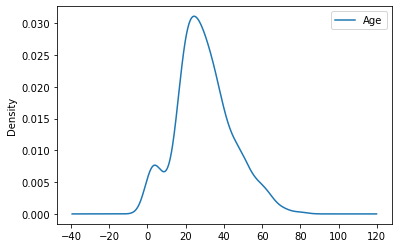

In [1344]:
fig = plt.figure()
ax = fig.add_subplot(111)
train['Age'].plot(kind='kde', ax=ax)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

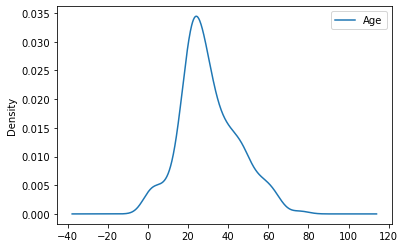

In [1345]:
fig = plt.figure()
ax = fig.add_subplot(111)
test['Age'].plot(kind='kde', ax=ax)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

<AxesSubplot:xlabel='Age'>

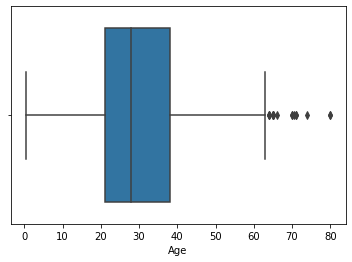

In [480]:
sns.boxplot(train.Age)

In [481]:
px.box(train,train.Age)

# AGE Outlier Detection

In [10]:
Q1 = train.Age.quantile(0.25)
Q3 = train.Age.quantile(0.75)
IQR = Q3 - Q1
IQR

17.0

In [11]:
lower = train.Age.quantile(0.25) - (IQR*1.5)
upper = train.Age.quantile(0.75) + (IQR*1.5)
lower , upper

(-4.5, 63.5)

In [12]:
age_drop_rows = train[train.Age > upper].index

In [13]:
train.drop(age_drop_rows,inplace = True)

# Checking Distribution

<AxesSubplot:xlabel='Age', ylabel='Count'>

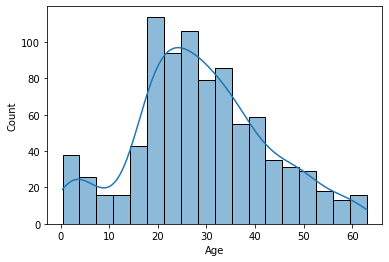

In [14]:
sns.histplot(train.Age,kde = True)

# Preparing Data For Modeling

In [15]:
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [16]:
low_cardinality_cols_train = [cname for cname in train.columns 
                              if train[cname].nunique() < 10 and train[cname].dtype == "object"]

In [17]:
low_cardinality_cols_train

['Sex', 'Embarked']

## Encoding

In [18]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
train_dummies = pd.DataFrame(ohe.fit_transform(train[['Sex', 'Embarked']]))
test_dummies = pd.DataFrame(ohe.transform(test[['Sex', 'Embarked']]))

In [19]:
train_dummies.columns = ['female', 'male','C', 'Q', 'S']
test_dummies.columns = ['female', 'male','C', 'Q', 'S']

In [20]:
train = pd.concat([train,train_dummies],axis = 1)
test = pd.concat([test,test_dummies],axis = 1)

In [21]:
train.drop(['Sex','PassengerId','Ticket','Cabin','Name','Embarked'],axis = 1 , inplace = True)
test.drop(['Sex','PassengerId','Ticket','Cabin','Name','Embarked'],axis = 1 , inplace = True)

# Modeling

In [22]:
x = train.drop('Survived',axis = 1)
y = train.Survived

In [34]:
kf = KFold(5)
kf

KFold(n_splits=5, random_state=None, shuffle=False)

In [36]:
(cross_val_score(LogisticRegression(),x,y,cv = kf)).mean()

0.7849458128078818

In [50]:
(cross_val_score(DecisionTreeClassifier(max_depth=10),x,y,cv = kf)).mean()

0.8009655172413794

In [23]:
xtrain , xtest , ytrain , ytest = train_test_split(x,y,train_size=0.8,random_state=4)

In [24]:
xtrain.shape , xtest.shape , ytrain.shape , ytest.shape

((699, 10), (175, 10), (699,), (175,))

In [25]:
models = pd.DataFrame(columns = ['MODEL','Accuracy Score'])

In [26]:
fst = model_acc(LogisticRegression(),xtrain,ytrain,xtest,ytest)

models = models.append({ 'MODEL' : 'Logistics Regression' ,
       'Accuracy Score' : fst ,
     },ignore_index=True)
model_acc(LogisticRegression() , xtrain , ytrain , xtest , ytest)

0.80571

In [27]:
fst = model_acc(DecisionTreeClassifier(max_depth=5),xtrain,ytrain,xtest,ytest)

models = models.append({ 'MODEL' : 'Decision Tree' ,
       'Accuracy Score' : fst ,
     },ignore_index=True)

model_acc(DecisionTreeClassifier(max_depth=5) , xtrain , ytrain , xtest , ytest)

0.82286

In [28]:
fst = model_acc(RandomForestClassifier(n_estimators=40),xtrain,ytrain,xtest,ytest)

models = models.append({ 'MODEL' : 'Random Forest' ,
       'Accuracy Score' : fst ,
     },ignore_index=True)

model_acc(RandomForestClassifier(n_estimators=40) , xtrain , ytrain , xtest , ytest)

0.79429

In [29]:
fst = model_acc(SVC(kernel='sigmoid'),xtrain,ytrain,xtest,ytest)

models = models.append({ 'MODEL' : 'Support Vector Machine' ,
       'Accuracy Score' : fst ,
     },ignore_index=True)

model_acc(SVC(kernel='sigmoid') , xtrain , ytrain , xtest , ytest)

0.65714

In [30]:
fst = model_acc(GaussianNB(),xtrain,ytrain,xtest,ytest)

models = models.append({ 'MODEL' : 'Naive Bayes' ,
       'Accuracy Score' : fst ,
     },ignore_index=True)

model_acc(GaussianNB() , xtrain , ytrain , xtest , ytest)

0.79429

In [31]:
models.sort_values('Accuracy Score',ascending=False)

,MODEL,Accuracy Score
1,Decision Tree,0.82286
0,Logistics Regression,0.80571
2,Random Forest,0.80571
4,Naive Bayes,0.79429
3,Support Vector Machine,0.65714


In [32]:
DTC = DecisionTreeClassifier(max_depth=5)
DTC.fit(xtrain,ytrain)

DecisionTreeClassifier(max_depth=5)

In [33]:
DTC.score(xtest,ytest)

0.8228571428571428

In [1406]:
ypred = DTC.predict(test)
ypred = pd.Series(ypred,name = 'Survived')

In [1407]:
submission = pd.concat([pass_id,ypred],axis = 1)

In [1408]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [1409]:
submission.to_csv('submission.csv',index=False)

In [ ]:
Q1 = train.Fare.quantile(0.25)
Q3 = train.Fare.quantile(0.75)
IQR = Q3 - Q1
lower = train.Fare.quantile(0.25) - (IQR*1.5)
upper = train.Fare.quantile(0.75) + (IQR*1.5)
fare_drop_rows = train[train.Fare > upper].index
train.drop(fare_drop_rows,axis = 0,inplace=True)

In [1196]:
Q1 = train.Fare.quantile(0.25)
Q3 = train.Fare.quantile(0.75)
IQR = Q3 - Q1
lower = train.Fare.quantile(0.25) - (IQR*1.5)
upper = train.Fare.quantile(0.75) + (IQR*1.5)
age_drop_rows = train[train.Fare > upper].index
age_drop_rows

Int64Index([  1,  27,  31,  32,  49,  57,  58,  68,  84,  97,
            ...
            777, 787, 805, 814, 820, 830, 833, 839, 846, 862],
           dtype='int64', length=113)

In [1197]:
Q1 = test.Fare.quantile(0.25)
Q3 = test.Fare.quantile(0.75)
IQR = Q3 - Q1
lower = test.Fare.quantile(0.25) - (IQR*1.5)
upper = test.Fare.quantile(0.75) + (IQR*1.5)
age_drop_rows = test[test.Fare > upper].index
age_drop_rows

Int64Index([ 12,  24,  48,  53,  59,  64,  69,  74,  75,  81,  96, 114, 118,
            141, 142, 150, 156, 179, 181, 184, 188, 196, 202, 212, 217, 218,
            234, 236, 239, 242, 252, 270, 272, 287, 293, 306, 308, 314, 316,
            324, 327, 342, 343, 352, 360, 365, 371, 374, 375, 390, 397, 400,
            407, 411, 414],
           dtype='int64')

In [1186]:
Q1 = train.Fare.quantile(0.25)
Q3 = train.Fare.quantile(0.75)
IQR = Q3 - Q1
IQR

22.998949999999997

In [1187]:
lower = train.Fare.quantile(0.25) - (IQR*1.5)
upper = train.Fare.quantile(0.75) + (IQR*1.5)
lower , upper

(-26.573424999999997, 65.42237499999999)

In [1188]:
# age_drop_rows = train[train.Age > upper].index
len(train[train.Fare > upper].index)
# train[train.Fare > upper]

113

In [1191]:
Q1 = test.Fare.quantile(0.25)
Q3 = test.Fare.quantile(0.75)
IQR = Q3 - Q1
IQR

23.576075

In [1192]:
lower = test.Fare.quantile(0.25) - (IQR*1.5)
upper = test.Fare.quantile(0.75) + (IQR*1.5)
lower , upper

(-27.468312499999996, 66.8359875)

In [1193]:
len(test[test.Fare > upper].index)

55